In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
# from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df=pd.read_csv('/content/sample_data/splunk_data_all_error_code-dcp-api-order-v3-prod.csv')

df.head(2)


,time,200,400,403,404,500,503
0,2021-04-15 12:46:00.000 PDT,0,0,0,0,0,0
1,2021-04-15 12:47:00.000 PDT,0,0,0,0,0,2


In [3]:
df1 = df.copy()  

In [4]:
df1['time1'] = pd.to_datetime(df1.time).dt.tz_localize(None)
df1.head()

,time,200,400,403,404,500,503,time1
0,2021-04-15 12:46:00.000 PDT,0,0,0,0,0,0,2021-04-15 12:46:00
1,2021-04-15 12:47:00.000 PDT,0,0,0,0,0,2,2021-04-15 12:47:00
2,2021-04-15 12:48:00.000 PDT,0,0,0,0,0,0,2021-04-15 12:48:00
3,2021-04-15 12:49:00.000 PDT,0,0,0,0,0,2,2021-04-15 12:49:00
4,2021-04-15 12:50:00.000 PDT,0,0,0,0,0,4,2021-04-15 12:50:00


In [5]:
df1['ds1'] = df1.time1.map(lambda x: x.strftime('%Y-%m-%d-%H-%M-%S'))
df1['ds'] = df1.time1.map(lambda x: x.strftime('%Y-%m-%d-%H'))
df1['ds2'] = df1.time1.map(lambda x: x.strftime('%Y-%m-%d-%H-%M'))
df1['ds3'] = df1.time1.map(lambda x: x.strftime('%Y-%m-%d'))
df1.head()

,time,200,400,403,404,500,503,time1,ds1,ds,ds2,ds3
0,2021-04-15 12:46:00.000 PDT,0,0,0,0,0,0,2021-04-15 12:46:00,2021-04-15-12-46-00,2021-04-15-12,2021-04-15-12-46,2021-04-15
1,2021-04-15 12:47:00.000 PDT,0,0,0,0,0,2,2021-04-15 12:47:00,2021-04-15-12-47-00,2021-04-15-12,2021-04-15-12-47,2021-04-15
2,2021-04-15 12:48:00.000 PDT,0,0,0,0,0,0,2021-04-15 12:48:00,2021-04-15-12-48-00,2021-04-15-12,2021-04-15-12-48,2021-04-15
3,2021-04-15 12:49:00.000 PDT,0,0,0,0,0,2,2021-04-15 12:49:00,2021-04-15-12-49-00,2021-04-15-12,2021-04-15-12-49,2021-04-15
4,2021-04-15 12:50:00.000 PDT,0,0,0,0,0,4,2021-04-15 12:50:00,2021-04-15-12-50-00,2021-04-15-12,2021-04-15-12-50,2021-04-15


In [6]:
df_day = df1[['ds3','200','400','403','404','500','503']]
# df_day.head()

In [7]:
df_day['ds3'] = pd.to_datetime(df_day.ds3, format="%Y-%m-%d")
df_day.tail()

,ds3,200,400,403,404,500,503
43196,2021-05-15,26,0,1,0,0,0
43197,2021-05-15,34,1,1,0,0,0
43198,2021-05-15,25,1,1,0,0,0
43199,2021-05-15,28,2,1,0,0,0
43200,2021-05-15,7,0,0,0,0,0


In [8]:
df_day1 = df_day.pivot_table(index=['ds3'], aggfunc='sum')
print(df_day1.shape)
df_day1.head()


(31, 6)


,200,400,403,404,500,503
ds3,,,,,,
2021-04-15,0,0,0,0,0,986
2021-04-16,6051,3,0,0,0,1156
2021-04-17,10612,0,0,0,0,0
2021-04-18,11510,0,0,0,0,0
2021-04-19,14501,1,0,0,0,0


In [9]:
df_day1 = df_day1.sort_values(by="ds3")

In [ ]:
# Analysis for hourly 500 error code

In [13]:
df_hour_400 = df1[['ds','400']]
print(df_hour_400.shape)
df_hour_400.head()

(43201, 2)


,ds,400
0,2021-04-15-12,0
1,2021-04-15-12,0
2,2021-04-15-12,0
3,2021-04-15-12,0
4,2021-04-15-12,0


In [ ]:
# df_hour_500.reset_index(inplace=True)

In [ ]:
# df_hour['ds'] = pd.to_datetime(df_hour.ds, format="%Y-%m-%d-%H")
# df_hour.head()

In [14]:
df_hour_400['ds'] = pd.to_datetime(df_hour_400['ds'])
df_hour_400 = df_hour_400.groupby('ds', as_index=False).agg({"400": "sum"})
df_hour_400.reset_index(inplace=True)
df_hour_400.rename(columns={'400': 'y'}, inplace=True)
df_hour_400 = df_hour_400.drop(['index'],axis = 1)

print(df_hour_400.shape)
df_hour_400

(721, 2)


,ds,y
0,2021-04-15 12:00:00,0
1,2021-04-15 13:00:00,0
2,2021-04-15 14:00:00,0
3,2021-04-15 15:00:00,0
4,2021-04-15 16:00:00,0
...,...,...
716,2021-05-15 08:00:00,75
717,2021-05-15 09:00:00,100
718,2021-05-15 10:00:00,92
719,2021-05-15 11:00:00,102


In [15]:
df = df_hour_400.copy()

In [16]:
df.ds = pd.to_datetime(df.ds)
df = df.set_index("ds")
df.head()

,y
ds,
2021-04-15 12:00:00,0
2021-04-15 13:00:00,0
2021-04-15 14:00:00,0
2021-04-15 15:00:00,0
2021-04-15 16:00:00,0


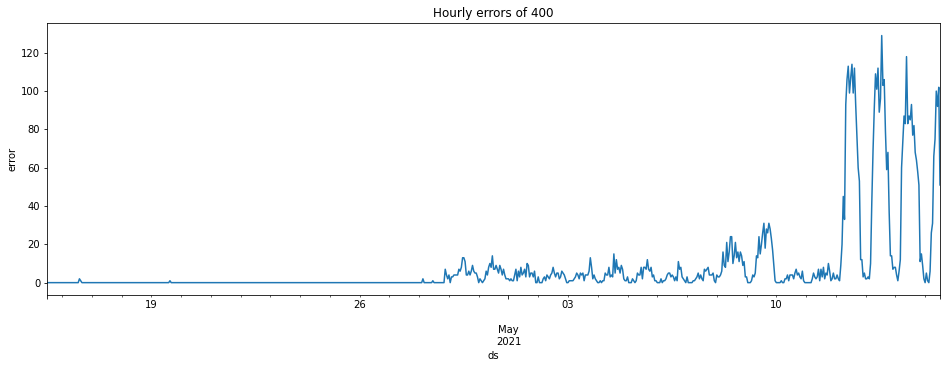

In [17]:
# df.index.freq = 'MS'

ax = df['y'].plot(figsize = (16,5), title = "Hourly errors of 400")
ax.set(xlabel='ds', ylabel='error');

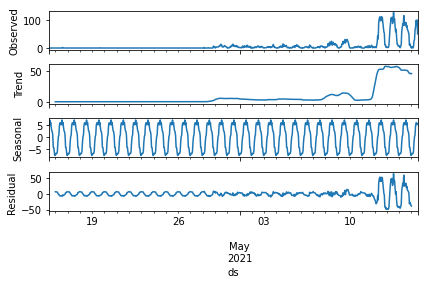

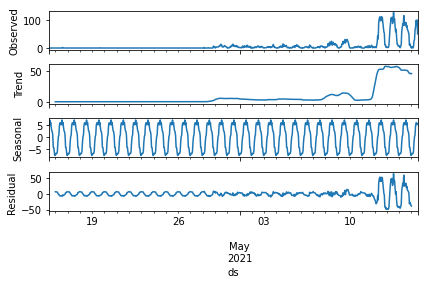

In [18]:
a = seasonal_decompose(df["y"], model = "add")
a.plot()

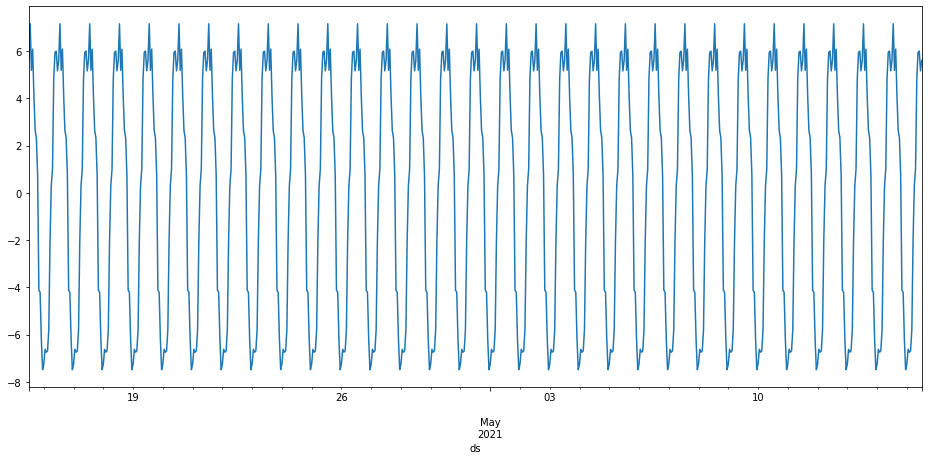

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

In [ ]:
# ARIMA Forecast

In [20]:
df1 = df.copy()
df1.head()

,y
ds,
2021-04-15 12:00:00,0
2021-04-15 13:00:00,0
2021-04-15 14:00:00,0
2021-04-15 15:00:00,0
2021-04-15 16:00:00,0


In [21]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [22]:
print(train_data.shape)
print(test_data.shape)
print(train_data.head())
print(train_data.tail(10))
print(test_data.head())
print(test_data.tail(10))

(709, 1)
(12, 1)
                     y
ds                    
2021-04-15 12:00:00  0
2021-04-15 13:00:00  0
2021-04-15 14:00:00  0
2021-04-15 15:00:00  0
2021-04-15 16:00:00  0
                      y
ds                     
2021-05-14 15:00:00  82
2021-05-14 16:00:00  68
2021-05-14 17:00:00  64
2021-05-14 18:00:00  58
2021-05-14 19:00:00  51
2021-05-14 20:00:00  11
2021-05-14 21:00:00  15
2021-05-14 22:00:00   9
2021-05-14 23:00:00   2
2021-05-15 00:00:00   0
                      y
ds                     
2021-05-15 01:00:00   5
2021-05-15 02:00:00   1
2021-05-15 03:00:00   0
2021-05-15 04:00:00   6
2021-05-15 05:00:00  26
                       y
ds                      
2021-05-15 03:00:00    0
2021-05-15 04:00:00    6
2021-05-15 05:00:00   26
2021-05-15 06:00:00   31
2021-05-15 07:00:00   66
2021-05-15 08:00:00   75
2021-05-15 09:00:00  100
2021-05-15 10:00:00   92
2021-05-15 11:00:00  102
2021-05-15 12:00:00   51


In [ ]:
arima_model = SARIMAX(train_data['y'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

In [68]:
arima_model = SARIMAX(train_data['y'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  709
Model:             SARIMAX(2, 1, 1)x(4, 0, 3, 12)   Log Likelihood               -2202.332
Date:                            Mon, 31 May 2021   AIC                           4426.664
Time:                                    07:03:59   BIC                           4476.851
Sample:                                04-15-2021   HQIC                          4446.054
                                     - 05-15-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2013      0.094      2.142      0.032       0.017       0.386
ar.L2          0.2676      0.025     10.639      0.000       0.218       0.317
ma.L1         -0.4395      0.102     -4.318      0.000      -0.639      -0.240
ar.S.L12      -1.0426      0.276     -3.782      0.000      -1.583      -0.502
ar.S.L24       0.1729      0.195      0.888      0.375      -0.209       0.555
ar.S.L36       0.6263      0.274      2.288      0.022       0.090       1.163
ar.S.L48       0.3041      0.074      4.084      0.000       0.158       0.450
ma.S.L12       0.8141      0.274      2.972      0.003       0.277       1.351
ma.S.L24      -0.0422      0.180     -0.234      0.815      -0.395       0.311
ma.S.L36      -0.2872      0.189     -1.521      0.128      -0.657       0.083
sigma2        29.0314      0.595     48.763      0.000      27.865      30.198
===================================================================================
Ljung-Box (Q):                      169.14   Jarque-Bera (JB):             13419.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):            1932.85   Skew:                             1.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2021-05-15 01:00:00    -2.001042
2021-05-15 02:00:00    -0.978309
2021-05-15 03:00:00    -1.971162
2021-05-15 04:00:00     4.463638
2021-05-15 05:00:00    27.016595
2021-05-15 06:00:00    41.649047
2021-05-15 07:00:00    48.696531
2021-05-15 08:00:00    65.703623
2021-05-15 09:00:00    75.224006
2021-05-15 10:00:00    67.905991
2021-05-15 11:00:00    65.049189
2021-05-15 12:00:00    66.921189
Freq: H, Name: ARIMA Predictions, dtype: float64

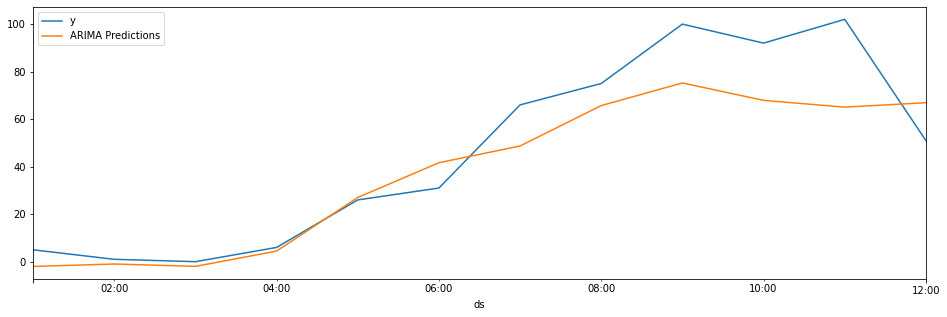

In [70]:
test_data['y'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [71]:
arima_rmse_error = rmse(test_data['y'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['y'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 281.0550323250117
RMSE Error: 16.76469601051602
Mean: 8.396671289875174


In [27]:
test_data['ARIMA_Predictions'] = arima_pred

Forecastung on next 50 hrs

In [98]:
# Forecast for the next 50 hrs
ARIMA_forecast_next50 = arima_result.predict(start = len(df1), 
                          end = (len(df1)-1) + 50, 
                          typ = 'levels').rename('Forecast')

In [145]:
ARIMA_forecast_next50.head()

2021-05-15 13:00:00    76.428527
2021-05-15 14:00:00    64.666960
2021-05-15 15:00:00    68.633301
2021-05-15 16:00:00    55.612931
2021-05-15 17:00:00    45.326958
Freq: H, Name: Forecast, dtype: float64

In [99]:
print(df1.tail())
print(ARIMA_forecast_next50.head())

                       y
ds                      
2021-05-15 08:00:00   75
2021-05-15 09:00:00  100
2021-05-15 10:00:00   92
2021-05-15 11:00:00  102
2021-05-15 12:00:00   51
2021-05-15 13:00:00    76.428527
2021-05-15 14:00:00    64.666960
2021-05-15 15:00:00    68.633301
2021-05-15 16:00:00    55.612931
2021-05-15 17:00:00    45.326958
Freq: H, Name: Forecast, dtype: float64


In [ ]:
ARIMA_forecast_next50.to_csv(r'/content/sample_data/ARIMA_forecast_next50hrs.csv')

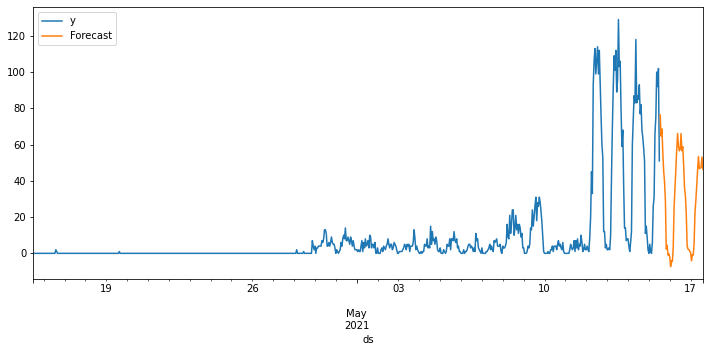

In [100]:
# Plot the forecast values
df1['y'].plot(figsize = (12, 5), legend = True)
ARIMA_forecast_next50.plot(legend = True)

Prophet Forecast

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 721 entries, 2021-04-15 12:00:00 to 2021-05-15 12:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       721 non-null    int64
dtypes: int64(1)
memory usage: 11.3 KB


In [29]:
df_pr = df.copy()
df_pr = df.reset_index()

In [30]:
df_pr.columns = ['ds','y']

In [31]:
train_data_pr = df_pr.iloc[:len(df)-12]
test_data_pr = df_pr.iloc[len(df)-12:]

In [32]:
from fbprophet import Prophet

In [33]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=62,freq='h')
prophet_pred = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [34]:
prophet_pred.shape

(771, 19)

In [35]:
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
766,2021-05-17 10:00:00,66.657791,50.164458,86.353866,65.762983,67.377636,2.235352,2.235352,2.235352,5.929612,5.929612,5.929612,-3.694260,-3.694260,-3.694260,0.0,0.0,0.0,68.893143
767,2021-05-17 11:00:00,66.934155,50.575463,86.560150,66.012430,67.675939,1.901442,1.901442,1.901442,5.901420,5.901420,5.901420,-3.999978,-3.999978,-3.999978,0.0,0.0,0.0,68.835597
768,2021-05-17 12:00:00,67.210518,51.568112,87.232350,66.262645,67.974816,1.589395,1.589395,1.589395,5.896485,5.896485,5.896485,-4.307090,-4.307090,-4.307090,0.0,0.0,0.0,68.799913
769,2021-05-17 13:00:00,67.486881,50.227996,87.251165,66.514841,68.277860,1.236391,1.236391,1.236391,5.849629,5.849629,5.849629,-4.613237,-4.613237,-4.613237,0.0,0.0,0.0,68.723272
770,2021-05-17 14:00:00,67.763244,49.515578,85.216643,66.758861,68.574311,0.649364,0.649364,0.649364,5.565331,5.565331,5.565331,-4.915967,-4.915967,-4.915967,0.0,0.0,0.0,68.412608


In [36]:
prophet_pred1 = prophet_pred.copy()

In [37]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})

In [38]:
prophet_pred = prophet_pred.set_index("Date")

In [39]:
prophet_pred.index.freq = "H"

In [40]:
prophet_pred

,Pred
Date,
2021-05-17 03:00:00,56.867246
2021-05-17 04:00:00,58.137753
2021-05-17 05:00:00,60.351460
2021-05-17 06:00:00,63.190868
2021-05-17 07:00:00,65.911137
2021-05-17 08:00:00,67.821448
2021-05-17 09:00:00,68.713483
2021-05-17 10:00:00,68.893143
2021-05-17 11:00:00,68.835597


In [41]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

In [42]:
import seaborn as sns

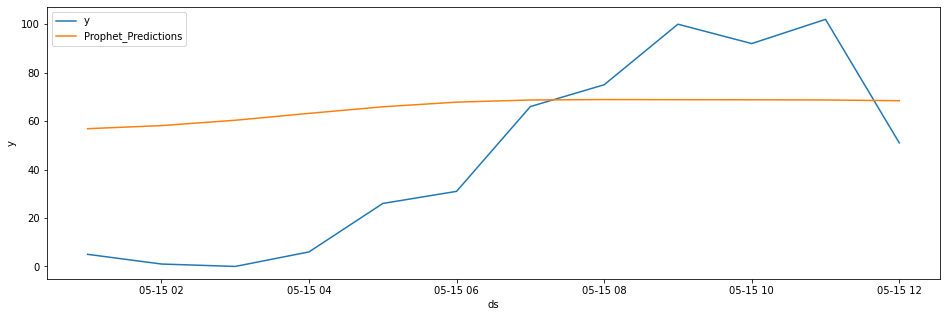

In [43]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["y"],label='y')
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"],label='Prophet_Predictions');

In [44]:
prophet_rmse_error = rmse(test_data['y'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['y'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 1565.1171930667526
RMSE Error: 39.5615620655549
Mean: 8.396671289875174


In [45]:
print(test_data['y'].shape)
print(test_data["Prophet_Predictions"].shape)
test_data.head(12)

(12,)
(12,)


,y,ARIMA_Predictions,Prophet_Predictions
ds,,,
2021-05-15 01:00:00,5,-2.001042,56.867246
2021-05-15 02:00:00,1,-0.978309,58.137753
2021-05-15 03:00:00,0,-1.971162,60.351460
2021-05-15 04:00:00,6,4.463638,63.190868
2021-05-15 05:00:00,26,27.016595,65.911137
2021-05-15 06:00:00,31,41.649047,67.821448
2021-05-15 07:00:00,66,48.696531,68.713483
2021-05-15 08:00:00,75,65.703623,68.893143
2021-05-15 09:00:00,100,75.224006,68.835597


In [46]:
 mape = np.mean(np.abs(test_data["Prophet_Predictions"] - test_data['y'])/np.abs(test_data['y']))  # MAPE
 mape

inf

Prophet forecast for next 50hrs

In [ ]:
prophet_pred1.tail(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
770,2021-05-17 14:00:00,-0.697415,-25.253834,17.789001,-2.900315,1.738048,-2.608525,-2.608525,-2.608525,-1.132998,-1.132998,-1.132998,-1.475527,-1.475527,-1.475527,0.0,0.0,0.0,-3.30594


In [ ]:
prophet_forecast_next50 = pd.DataFrame({"Date" : prophet_pred1[-50:]['ds'], "Pred" : prophet_pred1[-50:]["yhat"],"lower" : prophet_pred1[-50:]["yhat_lower"],"upper" : prophet_pred1[-50:]["yhat_upper"]})

In [ ]:
print(prophet_forecast_next50.shape)
prophet_forecast_next50.head()

(50, 4)


,Date,Pred,lower,upper
721,2021-05-15 13:00:00,-10.324568,-31.196078,11.563131
722,2021-05-15 14:00:00,-9.205074,-30.839209,12.868528
723,2021-05-15 15:00:00,-8.472254,-30.599009,13.353618
724,2021-05-15 16:00:00,-8.415795,-29.451611,12.474648
725,2021-05-15 17:00:00,-8.522790,-28.854189,12.685690


In [ ]:
prophet_forecast_next50.to_csv(r'/content/sample_data/Prophet_forecast_next50hrs.csv')

In [ ]:
forecast = pd.DataFrame({"ds" : prophet_pred1[-50:]['ds'], "y" : prophet_pred1[-50:]["yhat"]})
forecast.head()

,ds,y
721,2021-05-15 13:00:00,-10.324568
722,2021-05-15 14:00:00,-9.205074
723,2021-05-15 15:00:00,-8.472254
724,2021-05-15 16:00:00,-8.415795
725,2021-05-15 17:00:00,-8.522790


In [ ]:
print(df1.tail())
print(forecast.head())

                      y
ds                     
2021-05-15 08:00:00  12
2021-05-15 09:00:00  13
2021-05-15 10:00:00  16
2021-05-15 11:00:00  16
2021-05-15 12:00:00  15
                             y
ds                            
2021-05-15 13:00:00  12.153541
2021-05-15 14:00:00  12.147752
2021-05-15 15:00:00  11.926505
2021-05-15 16:00:00  11.600720
2021-05-15 17:00:00  11.298742


LSTM Forecast

In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [48]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [49]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(500, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500)               1004000   
_________________________________________________________________
dense (Dense)                (None, 1)                 501       
Total params: 1,004,501
Trainable params: 1,004,501
Non-trainable params: 0
_________________________________________________________________


In [51]:
lstm_model.fit_generator(generator,epochs=30)

Epoch 1/30
697/697 [==============================] - 46s 34ms/step - loss: 0.0162
Epoch 2/30
697/697 [==============================] - 24s 34ms/step - loss: 0.0115
Epoch 3/30
697/697 [==============================] - 24s 35ms/step - loss: 0.0047
Epoch 4/30
697/697 [==============================] - 24s 35ms/step - loss: 0.0041
Epoch 5/30
697/697 [==============================] - 24s 34ms/step - loss: 0.0038
Epoch 6/30
697/697 [==============================] - 24s 34ms/step - loss: 0.0029
Epoch 7/30
697/697 [==============================] - 24s 34ms/step - loss: 0.0020
Epoch 8/30
697/697 [==============================] - 24s 35ms/step - loss: 0.0025
Epoch 9/30
697/697 [==============================] - 24s 34ms/step - loss: 0.0021
Epoch 10/30
697/697 [==============================] - 24s 35ms/step - loss: 0.0023
Epoch 11/30
697/697 [==============================] - 24s 34ms/step - loss: 0.0020
Epoch 12/30
697/697 [==============================] - 24s 34ms/step - loss: 0.0016
E

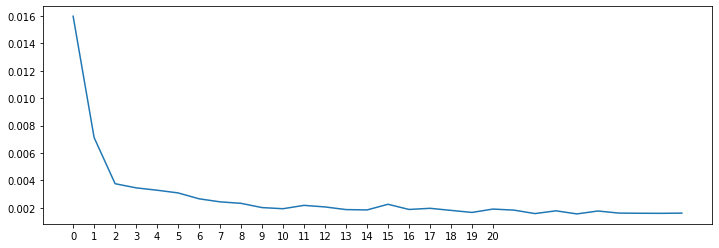

In [52]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [53]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [54]:
lstm_predictions_scaled

[array([0.00115853], dtype=float32),
 array([0.01143887], dtype=float32),
 array([0.01182656], dtype=float32),
 array([0.02900061], dtype=float32),
 array([0.04460555], dtype=float32),
 array([0.08447988], dtype=float32),
 array([0.20414351], dtype=float32),
 array([0.24680883], dtype=float32),
 array([0.39720684], dtype=float32),
 array([0.5293055], dtype=float32),
 array([0.61681783], dtype=float32),
 array([0.6608839], dtype=float32)]

In [55]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [56]:
lstm_predictions

array([[ 0.14945012],
       [ 1.47561409],
       [ 1.52562623],
       [ 3.7410787 ],
       [ 5.75411636],
       [10.89790399],
       [26.3345127 ],
       [31.83833867],
       [51.23968273],
       [68.28041178],
       [79.56950033],
       [85.25402355]])

In [57]:
test_data['LSTM_Predictions'] = lstm_predictions

In [58]:
test_data

,y,ARIMA_Predictions,Prophet_Predictions,LSTM_Predictions
ds,,,,
2021-05-15 01:00:00,5,-2.001042,56.867246,0.149450
2021-05-15 02:00:00,1,-0.978309,58.137753,1.475614
2021-05-15 03:00:00,0,-1.971162,60.351460,1.525626
2021-05-15 04:00:00,6,4.463638,63.190868,3.741079
2021-05-15 05:00:00,26,27.016595,65.911137,5.754116
2021-05-15 06:00:00,31,41.649047,67.821448,10.897904
2021-05-15 07:00:00,66,48.696531,68.713483,26.334513
2021-05-15 08:00:00,75,65.703623,68.893143,31.838339
2021-05-15 09:00:00,100,75.224006,68.835597,51.239683


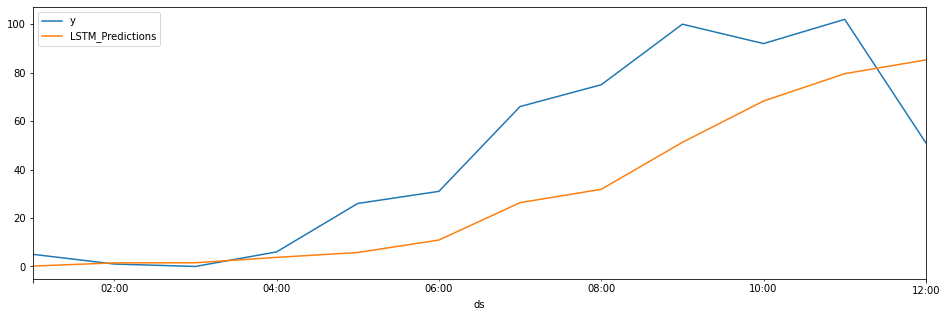

In [59]:
test_data['y'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [60]:
lstm_rmse_error = rmse(test_data['y'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['y'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 741.5089261896304
RMSE Error: 27.23066150848397
Mean: 8.396671289875174


In [ ]:
# ARIMA accuracy

MSE Error: 8.192693185188205
RMSE Error: 2.862288103107059
Mean: 1.1678224687933425

# Prophet accuracy

MSE Error: 42.58929012875238
RMSE Error: 6.526047052293784
Mean: 1.1678224687933425

# LSTM accuracy

MSE Error: 61.72525147908522
RMSE Error: 7.856541954262398
Mean: 1.1678224687933425

In [61]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

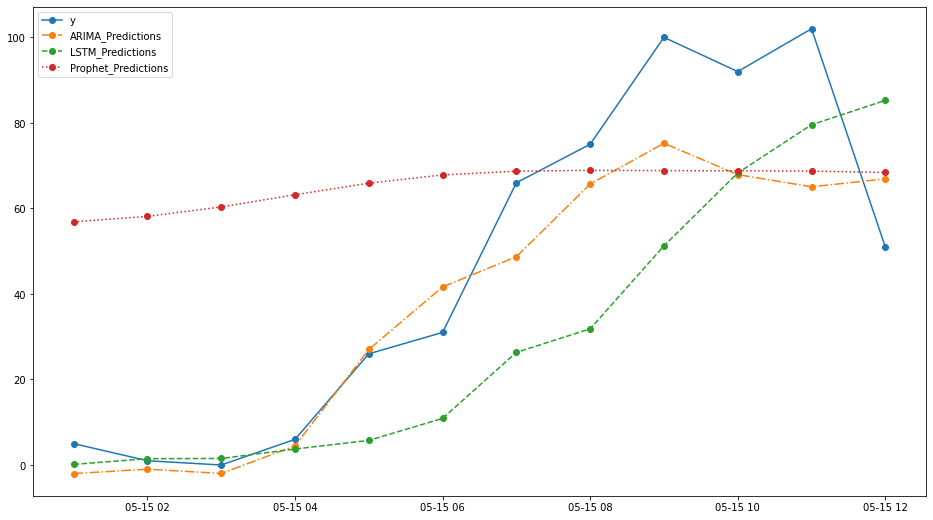

In [62]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["y"], linestyle="-",label='y')
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.",label='ARIMA_Predictions')
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--",label='LSTM_Predictions')
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":",label='Prophet_Predictions')
plt.legend()

plt.show()

In [63]:
print(f"Mean: {test_data['y'].mean()}")
errors

Mean: 46.25


,Models,RMSE Errors,MSE Errors
0,ARIMA,16.764696,281.055032
1,LSTM,27.230662,741.508926
2,Prophet,39.561562,1565.117193


In [ ]:
test_data

,y,Prophet_Predictions,LSTM_Predictions,ARIMA_Predictions
ds,,,,
2021-05-15 01:00:00,1,9.217985,-0.142948,-3.707930
2021-05-15 02:00:00,0,9.322739,0.104450,-2.342556
2021-05-15 03:00:00,0,9.500386,4.649295,1.958447
2021-05-15 04:00:00,0,9.843611,11.999605,2.002282
2021-05-15 05:00:00,2,10.353241,18.366560,6.393724
2021-05-15 06:00:00,4,10.898845,17.373522,8.066059
2021-05-15 07:00:00,10,11.301295,16.865167,12.428910
2021-05-15 08:00:00,12,11.473225,18.157376,14.050522
2021-05-15 09:00:00,13,11.490573,19.844532,13.272397


In [ ]:
test_data.to_csv(r'/content/sample_data/500_error_final_modelprediction.csv')